In [2]:
import torch
import torch.onnx as onnx
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
training_data = torchvision.datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                                             )
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

C:\Users\Alex Vogt\AppData\Local\Programs\Python\Python36\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_dataloader = DataLoader(training_data, 64, shuffle=True)
epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10
batch_size = 64

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [6]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [7]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CUDA Available:  False


In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
def train_loop_adv(dataloader, model, loss_fn, optimizer, epsilon):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        data.requires_grad = True
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Adversarial Training portion
        
        # Compute prediction and loss
        perturbed_data = pgd_linf(model, data, target, epsilon, 0.5, 3)
        pred2 = model(perturbed_data)
        loss = loss_fn(pred2, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------


C:\Users\Alex Vogt\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.371851  [    0/60000]
loss: 2.271594  [ 6400/60000]
loss: 2.022966  [12800/60000]
loss: 1.571283  [19200/60000]
loss: 1.110567  [25600/60000]
loss: 0.983823  [32000/60000]
loss: 1.006886  [38400/60000]
loss: 0.721677  [44800/60000]
loss: 0.717591  [51200/60000]
loss: 0.761637  [57600/60000]
Epoch 2
-------------------------------
loss: 0.544061  [    0/60000]
loss: 0.785124  [ 6400/60000]
loss: 0.731310  [12800/60000]
loss: 0.420542  [19200/60000]
loss: 0.577693  [25600/60000]
loss: 0.393296  [32000/60000]
loss: 0.451141  [38400/60000]
loss: 0.388598  [44800/60000]
loss: 0.564039  [51200/60000]
loss: 0.415227  [57600/60000]
Epoch 3
-------------------------------
loss: 0.514894  [    0/60000]
loss: 0.385397  [ 6400/60000]
loss: 0.555294  [12800/60000]
loss: 0.404189  [19200/60000]
loss: 0.438489  [25600/60000]
loss: 0.443254  [32000/60000]
loss: 0.435240  [38400/60000]
loss: 0.406224  [44800/60000]
loss: 0.499427  [51200/60000]
loss: 0.362186  [57600/60000]
Epoch 4
------------

In [11]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [12]:
def PGD_attack(model, image, y, epsilon, alpha, num_iterations):
    base = image.clone().detach().requires_grad_(True).to(device)
    y = y.to(device)
    for count in range(num_iterations):
        perturbed_image = base.clone().detach().requires_grad_(True)
        loss = nn.CrossEntropyLoss()(model(perturbed_image), y)
        loss.backward()
        base += perturbed_image.grad.sign() * alpha
        base = torch.max(torch.min(perturbed_image, image + eps), image - eps).clamp(0,1)

    return base

In [13]:
def pgd_linf(model, x, y, eps, alpha, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    y = y.to(device)
    for i in range(num_iter):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
        loss = nn.CrossEntropyLoss()(model(_x_adv), y)
        loss.backward()

        with torch.no_grad():
            x_adv += _x_adv.grad.sign() * alpha

        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps).clamp(0,1)

    return x_adv.detach()

In [14]:
def test( model, device, test_loader, epsilon, realValue):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = pgd_linf(model, data, target, epsilon, 0.5, 3)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if realValue == 1:
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == init_pred.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 1)
    accuracies.append(acc)
    examples.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9776 / 10000 = 0.9776
Epsilon: 0.05	Test Accuracy = 9307 / 10000 = 0.9307
Epsilon: 0.1	Test Accuracy = 8033 / 10000 = 0.8033
Epsilon: 0.15	Test Accuracy = 5483 / 10000 = 0.5483
Epsilon: 0.2	Test Accuracy = 2527 / 10000 = 0.2527
Epsilon: 0.25	Test Accuracy = 928 / 10000 = 0.0928
Epsilon: 0.3	Test Accuracy = 271 / 10000 = 0.0271


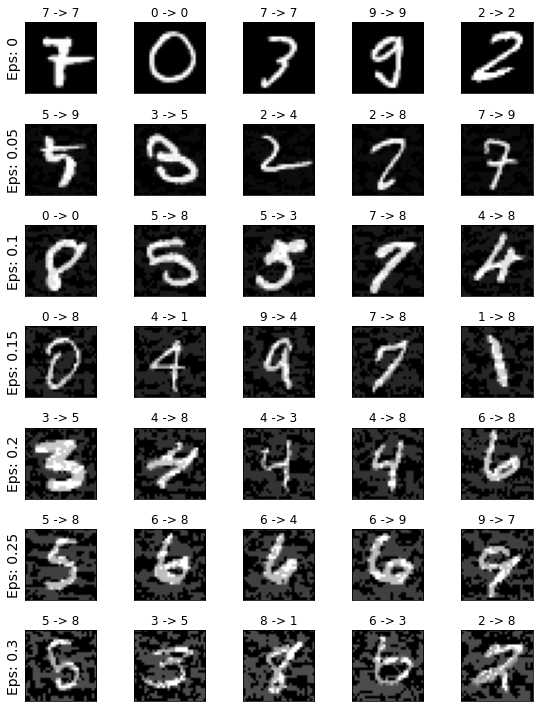

In [16]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),5,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        currArr = examples[i]
        orig,adv,ex = currArr[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

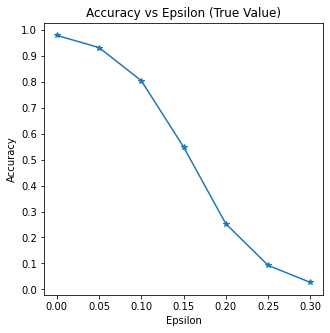

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [18]:
accuracies2 = []
examples2 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 0)
    accuracies2.append(acc)
    examples2.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 10000 / 10000 = 1.0
Epsilon: 0.05	Test Accuracy = 9505 / 10000 = 0.9505
Epsilon: 0.1	Test Accuracy = 8217 / 10000 = 0.8217
Epsilon: 0.15	Test Accuracy = 5646 / 10000 = 0.5646
Epsilon: 0.2	Test Accuracy = 2669 / 10000 = 0.2669
Epsilon: 0.25	Test Accuracy = 1053 / 10000 = 0.1053
Epsilon: 0.3	Test Accuracy = 388 / 10000 = 0.0388


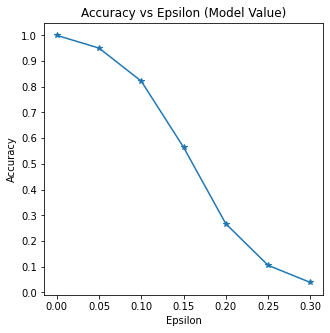

In [19]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [22]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_adv(train_dataloader, model, loss_fn, optimizer, epsilon = 0.3)
print("Done!")

Epoch 1
-------------------------------
loss: 0.420153  [    0/60000]
loss: 0.246833  [ 6400/60000]
loss: 0.125706  [12800/60000]
loss: 0.170002  [19200/60000]
loss: 0.162469  [25600/60000]
loss: 0.181006  [32000/60000]
loss: 0.150682  [38400/60000]
loss: 0.072148  [44800/60000]
loss: 0.182131  [51200/60000]
loss: 0.148036  [57600/60000]
Epoch 2
-------------------------------
loss: 0.216369  [    0/60000]
loss: 0.127626  [ 6400/60000]
loss: 0.187166  [12800/60000]
loss: 0.128720  [19200/60000]
loss: 0.076908  [25600/60000]
loss: 0.156144  [32000/60000]
loss: 0.120033  [38400/60000]
loss: 0.164486  [44800/60000]
loss: 0.162733  [51200/60000]
loss: 0.071970  [57600/60000]
Epoch 3
-------------------------------
loss: 0.231941  [    0/60000]
loss: 0.060214  [ 6400/60000]
loss: 0.160092  [12800/60000]
loss: 0.066166  [19200/60000]
loss: 0.070754  [25600/60000]
loss: 0.046085  [32000/60000]
loss: 0.148950  [38400/60000]
loss: 0.094913  [44800/60000]
loss: 0.181327  [51200/60000]
loss: 0.11

In [23]:
accuracies3 = []
examples3 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 1)
    accuracies3.append(acc)
    examples3.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9909 / 10000 = 0.9909
Epsilon: 0.05	Test Accuracy = 9571 / 10000 = 0.9571
Epsilon: 0.1	Test Accuracy = 8478 / 10000 = 0.8478
Epsilon: 0.15	Test Accuracy = 5812 / 10000 = 0.5812
Epsilon: 0.2	Test Accuracy = 2466 / 10000 = 0.2466
Epsilon: 0.25	Test Accuracy = 623 / 10000 = 0.0623
Epsilon: 0.3	Test Accuracy = 94 / 10000 = 0.0094


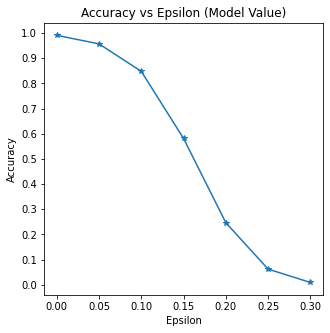

In [24]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies3, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [25]:
accuracies4 = []
examples4 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 0)
    accuracies4.append(acc)
    examples4.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 10000 / 10000 = 1.0
Epsilon: 0.05	Test Accuracy = 9661 / 10000 = 0.9661
Epsilon: 0.1	Test Accuracy = 8566 / 10000 = 0.8566
Epsilon: 0.15	Test Accuracy = 5900 / 10000 = 0.59
Epsilon: 0.2	Test Accuracy = 2548 / 10000 = 0.2548
Epsilon: 0.25	Test Accuracy = 703 / 10000 = 0.0703
Epsilon: 0.3	Test Accuracy = 173 / 10000 = 0.0173


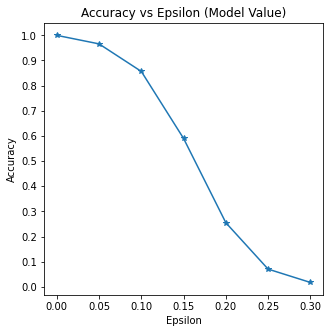

In [26]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies4, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

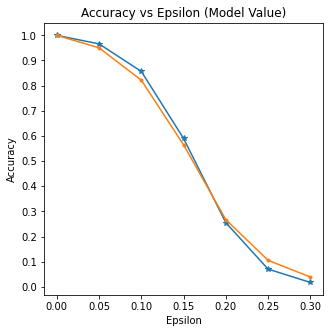

In [27]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies4, "*-")
plt.plot(epsilons, accuracies2, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

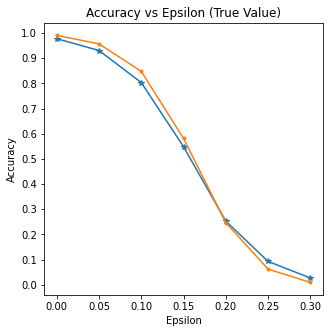

In [28]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, accuracies3, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()